# Color Name CNN Classifier

Train a CNN to predict color names from RGB values

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [4]:
# Configuration
TOP_N_COLORS = 329  # Number of top colors to train on
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

# Auto-detect best available device (CUDA GPU > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device} ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: {device} (Apple Silicon)")
else:
    device = torch.device('cpu')
    print(f"Using device: {device}")

Using device: mps (Apple Silicon)


## Load and Prepare Data

In [5]:
# # Upload the CSV file (run this in Colab)
# from google.colab import files
# uploaded = files.upload()  # Select mainsurvey_data.csv when prompted

In [6]:
# Load data from CSV
df = pd.read_csv('mainsurvey_data.csv')

print(f"Total samples: {len(df):,}")

# Get top N colors
top_colors = df['colorname'].value_counts().head(TOP_N_COLORS).index
df_filtered = df[df['colorname'].isin(top_colors)].copy()

print(f"Filtered to top {TOP_N_COLORS} colors: {len(df_filtered):,} samples")
print(f"Coverage: {len(df_filtered)/len(df)*100:.1f}%")

Total samples: 3,408,036
Filtered to top 329 colors: 2,725,062 samples
Coverage: 80.0%
Filtered to top 329 colors: 2,725,062 samples
Coverage: 80.0%


In [7]:
# Prepare features and labels
X = df_filtered[['r', 'g', 'b']].values.astype(np.float32) / 255.0  # Normalize to [0, 1]
y = df_filtered['colorname'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Input shape: {X.shape}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Number of classes: 329
Input shape: (2725062, 3)
Train samples: 2,180,049
Test samples: 545,013
Train samples: 2,180,049
Test samples: 545,013


## Dataset and DataLoader

In [8]:
class ColorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ColorDataset(X_train, y_train)
test_dataset = ColorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches per epoch: {len(train_loader)}")

Batches per epoch: 17032


## 3-Layer CNN Model

In [9]:
class ColorCNN(nn.Module):
    def __init__(self, num_classes):
        super(ColorCNN, self).__init__()
        
        # Reshape input from (batch, 3) to (batch, 3, 1, 1) for conv layers
        # Layer 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        
        # Layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        
        # Layer 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        
        # Fully connected
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Reshape from (batch, 3) to (batch, 3, 1, 1)
        x = x.unsqueeze(-1).unsqueeze(-1)
        
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_classes = len(label_encoder.classes_)
model = ColorCNN(num_classes).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

ColorCNN(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=256, out_features=329, bias=True)
)

Total parameters: 127,049


## Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += y_batch.size(0)
        train_correct += predicted.eq(y_batch).sum().item()
    
    # Testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += y_batch.size(0)
            test_correct += predicted.eq(y_batch).sum().item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc = 100. * train_correct / train_total
    test_acc = 100. * test_correct / test_total
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch 1/20: Train Loss: 2.3691, Train Acc: 42.13% | Test Loss: 2.2952, Test Acc: 43.27%
Epoch 2/20: Train Loss: 2.3347, Train Acc: 42.55% | Test Loss: 2.2874, Test Acc: 43.28%
Epoch 2/20: Train Loss: 2.3347, Train Acc: 42.55% | Test Loss: 2.2874, Test Acc: 43.28%
Epoch 3/20: Train Loss: 2.3176, Train Acc: 42.78% | Test Loss: 2.2881, Test Acc: 43.25%
Epoch 3/20: Train Loss: 2.3176, Train Acc: 42.78% | Test Loss: 2.2881, Test Acc: 43.25%
Epoch 4/20: Train Loss: 2.3073, Train Acc: 42.93% | Test Loss: 2.2863, Test Acc: 43.26%
Epoch 4/20: Train Loss: 2.3073, Train Acc: 42.93% | Test Loss: 2.2863, Test Acc: 43.26%
Epoch 5/20: Train Loss: 2.3009, Train Acc: 43.01% | Test Loss: 2.2856, Test Acc: 43.28%
Epoch 5/20: Train Loss: 2.3009, Train Acc: 43.01% | Test Loss: 2.2856, Test Acc: 43.28%
Epoch 6/20: Train Loss: 2.2966, Train Acc: 43.04% | Test Loss: 2.2853, Test Acc: 43.28%
Epoch 6/20: Train Loss: 2.2966, Train Acc: 43.04% | Test Loss: 2.2853, Test Acc: 43.28%
Epoch 7/20: Train Loss: 2.2931, 

## Results

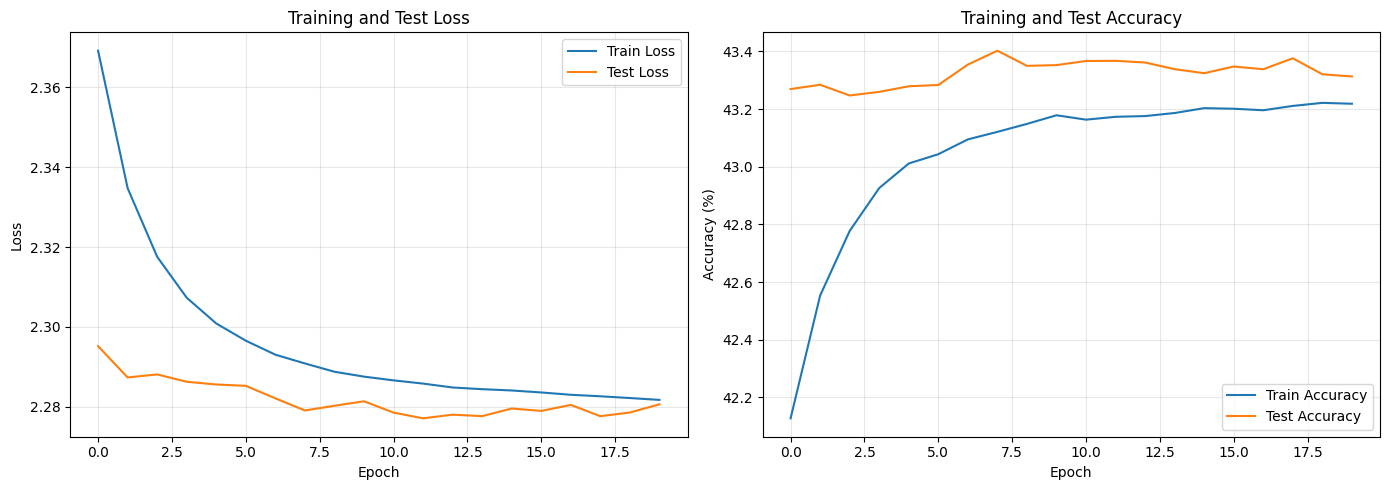


Final Test Accuracy: 43.31%


In [11]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {test_accs[-1]:.2f}%")

In [14]:
# Test with some example colors - including boundary cases
test_colors = [
    # Basic saturated colors
    ([255, 0, 0], "red"),
    ([0, 255, 0], "green"),
    ([0, 0, 255], "blue"),
    ([255, 192, 203], "pink"),
    ([128, 0, 128], "purple"),
    
    # Boundary colors - between categories
    ([255, 128, 0], "orange/red boundary"),
    ([128, 255, 0], "yellow-green/lime boundary"),
    ([0, 128, 128], "teal/cyan boundary"),
    ([128, 0, 64], "purple/magenta boundary"),
    ([64, 0, 128], "purple/indigo boundary"),
    
    # Desaturated/pastel colors
    ([200, 200, 200], "light gray"),
    ([100, 100, 100], "medium gray"),
    ([255, 255, 224], "very light yellow/cream"),
    ([230, 230, 250], "lavender"),
    ([255, 228, 196], "bisque/peach"),
    
    # Dark colors
    ([139, 0, 0], "dark red"),
    ([0, 100, 0], "dark green"),
    ([25, 25, 112], "midnight blue"),
    
    # Earth tones
    ([165, 42, 42], "brown"),
    ([210, 180, 140], "tan"),
    ([128, 128, 0], "olive")
]

model.eval()
print("Testing model on boundary and ambiguous colors:\n")
with torch.no_grad():
    for rgb, expected in test_colors:
        rgb_norm = torch.FloatTensor([r/255.0 for r in rgb]).unsqueeze(0).to(device)
        output = model(rgb_norm)
        _, predicted = output.max(1)
        predicted_name = label_encoder.inverse_transform(predicted.cpu().numpy())[0]
        rgb_str = str(rgb).ljust(20)
        print(f"RGB {rgb_str} -> Predicted: '{predicted_name:20}' (Expected: {expected})")


Testing model on boundary and ambiguous colors:

RGB [255, 0, 0]          -> Predicted: 'red                 ' (Expected: red)
RGB [0, 255, 0]          -> Predicted: 'green               ' (Expected: green)
RGB [0, 0, 255]          -> Predicted: 'blue                ' (Expected: blue)
RGB [255, 192, 203]      -> Predicted: 'pink                ' (Expected: pink)
RGB [128, 0, 128]        -> Predicted: 'purple              ' (Expected: purple)
RGB [255, 128, 0]        -> Predicted: 'orange              ' (Expected: orange/red boundary)
RGB [128, 255, 0]        -> Predicted: 'green               ' (Expected: yellow-green/lime boundary)
RGB [0, 128, 128]        -> Predicted: 'teal                ' (Expected: teal/cyan boundary)
RGB [128, 0, 64]         -> Predicted: 'purple              ' (Expected: purple/magenta boundary)
RGB [64, 0, 128]         -> Predicted: 'purple              ' (Expected: purple/indigo boundary)
RGB [200, 200, 200]      -> Predicted: 'grey                ' (Expected